# Generating Sound & Music with Genetic Algorithms

Genetic Algorithms are a subset of evolutionary computing; biologically inspired optimization with population-based trial and error search. Loosely speaking, a genetic algortihm creates a popultation of entities that can be modified, combined, and evaluated for fitness with respect to an optimization goal. The simplest optimization step works as follows; create a population, check which elements are most fit (best suited to the optimization problem), keep only the most fit, modify and recombine elements to create new element for the next generation, repeat.

### The components:
- genetic representation
- population
- genetic operations: mutation and recombination
- fitness
- selection
- sources of randomness


### Introduction Example:

Genetic algorithms are inspired by natural selection. Here is a simple simulation of natural selection (choose the lab): https://phet.colorado.edu/sims/html/natural-selection/latest/natural-selection_en.html

- note all the ways you can change the genetic operations
- note all the ways you can change the fitness function

## The genetic algorithm in this notebook

### The components in the code:
- genetic representation: each element is a chord progression with 8 chords
- population: the population consists of 60 
- genetic operations: 
1) point mutation of progression; randomly choose a chord and invert it or add an accidental
2) recombination of progression; create a mix and match of two sequences
- fitness: 
1) penalize and encourage several pitch relationships between adjacent chords
2) penalize and encourage several pitch relationships with an existing notes
- selection: pick the best 30 progressions and add 30 new ones
- sources of randomness: in the mutation and recombination as well as adding random new ones.

### Getting to know the code:

1. understand the code below and get an overall idea of what the algorithm looks like, maybe draw a flow chart or take some notes.
2. play around with the optimization loop while changing the modify function: do you see things that could be changed in the genetic representation? what are they and can you change them?
3. write a two step selection; first mutate/modify elements and select the fittest (with some randomness), then recombine them and select the fittest from offspring and parent elements (with some randomness)
4. modify the fitness function that returns a score for how well the melody fits the progression. 
5. change the modify function, such that some parts of the genetic representation (the chord sequence) can be fixed (made immutable). This is the most complex task and probably requires some thinking, creativity, and experimentation. Take your time!

In [13]:
import partitura as pt
import numpy as np
from scipy.spatial.distance import pdist
from itertools import product
import random, string
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from partitura.utils.synth import synthesize
import IPython.display as ipd
from helpers import (partFromProgression, addnote, parttimefromrekorder, addmelody2part)



In [2]:
def cycle_distance(u,v):
    """
    pitch class distance between two values u and v
    """
    a = np.sqrt(((u%12-v%12)%12)**2)
    b = np.sqrt(((v%12-u%12)%12)**2)
    return np.min([a, b])

def chordDistance(c1, c2):
    """
    compute the minimal distance between to chords
    when every note of the second chord
    can be transposed by up to -1 / +1 octaves 
    
    """
    l = min(c1.shape[0],c2.shape[0])
    c1 = c1[:l]
    c2 = c2[:l]
    local_adds = dict()
    adds = []
    for comb in product(np.arange(-1,1), repeat =  l):
        c=np.array(comb)
        new_c2 = c2 + 12* c
        # pd = pdist(new_c2.reshape(-1,1), cycle_distance)
        total = np.sum(np.abs(new_c2-c1))
        adds.append(total)
        local_adds[total] = c
    
    best_total = np.min(adds)
    best_adds = local_adds[best_total]
    # print("best adds", best_adds, "best_total", best_total)
    
    return  best_adds, best_total

def randomword(length):
    """
    a random character generator
    """
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))

In [3]:
class Progression:
    """
    the Progression class representing a sequence of chords
    """
    def __init__(self, chords = None):
        self.chords = [Chord() for c in range(8)]
        self.id = randomword(10)
    
    
    def join(self, another):
        #idx to keep
        idx = np.unique(np.random.randint(0,8,4))
        new_progression = Progression()
        new_another_progression = Progression()
        for k in range(8):
            if k in idx:
                new_progression.chords[k] = self.chords[k]
                new_another_progression.chords[k] = another.chords[k]
            else:
                new_progression.chords[k] = another.chords[k]
                new_another_progression.chords[k] = self.chords[k]
        return new_progression, new_another_progression
                
        
        

In [4]:
class Chord:
    """
    the Chord class representing a chord made of 3-4 notes of a scale.
    For diatonic scales the intervals between notes are thirds.
    """
    def __init__(self, 
                 offset = 48, #np.random.randint(48,60)-12, 
                 scale = np.array([0,2,4,5,7,9,11]),
                 root_id = None
                ):
        self.offset = offset
        self.scale = scale
        if root_id is None:
            self.root_id = np.random.randint(self.scale.shape[0])
        else:
            self.root_id = root_id
        self.root = self.offset + self.scale[self.root_id]
        self.how_many = np.random.randint(3,5)
        if self.how_many == 3:
            self.jumps = [2,2,3]
        elif self.how_many == 4:
            self.jumps = [2,2,2,1]
        self.jumps_cs = np.cumsum([0]+ self.jumps) 
        self.inversion = 0
        self.inversion_jumps = None
        self.inversion_jumps_cs = None
        self.all_ids = None
        self.pitches = None
        self.pitch_classes = None
        self.pitch_classes_relative = None
        self.repitch = [0,0]
        self.compute_pitch()
        self.name = self.get_name()
        
    def get_name(self):
        root_names = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
        root_name = root_names[self.root%12]
        first_jump =  cycle_distance(self.scale[(self.root_id+self.jumps[0])%self.scale.shape[0]],
                                      self.scale[self.root_id])
        if first_jump == 3:
            mod = "m"
        elif first_jump == 4:
            mod = "M"
        else:
            mod = "?"
        
        if self.how_many == 3:
            typ = ""
        elif self.how_many == 4:
            typ = "7"
        elif self.how_many == 5:
            typ = "79"
        else:
            typ = "jazz?"
            
        repitch_names = {1:"#", -1:"b"}
        if self.repitch != [0,0]:
            chromatic = "_" + str(self.repitch[0]) +repitch_names[self.repitch[1]]
        else:
            chromatic = ""
        name = root_name + mod + typ + "_" + str(self.inversion) + chromatic
        return name
        
    def compute_pitch(self):
        self.inversion_jumps = self.jumps[self.inversion:]+self.jumps[:self.inversion]
        self.inversion_jumps_cs = np.cumsum([0]+ self.inversion_jumps) 
        self.all_ids = np.array([(self.root_id+self.jumps_cs[self.inversion])%self.scale.shape[0]
                                 +self.inversion_jumps_cs[n] for n in range(self.how_many)])
        self.pitches = self.offset + np.concatenate((self.scale, self.scale+12))[self.all_ids]
        self.pitches[self.repitch[0]] += self.repitch[1]
        self.pitch_classes = self.pitches%12
        self.pitch_classes_relative = (self.pitches-self.offset)%12
        self.name = self.get_name()
        
    
    def invert(self, n):
        n %= self.how_many
        self.inversion = n
        self.compute_pitch()
        
    def add_repitch(self, idx, mod):
        idx %= self.how_many
        self.repitch = [idx, mod]
        self.compute_pitch()
    

In [5]:
"""
MODIFIERS
"""
def modify(population):
    
    # add an accidental
    subpop3 = np.random.choice(population, 30)
    for element in subpop3:
        cidx = np.random.randint(len(element.chords))
        nidx = np.random.randint(4)
        mod = np.random.choice([-1,1])
        new_element = Progression(element.chords)
        new_element.chords[cidx].add_repitch(nidx,mod)
        population.append(new_element)
    
    # invert a chord
    subpop4 = np.random.choice(population, 30)
    for element in subpop4:
        cidx = np.random.randint(len(element.chords))
        nidx = np.random.randint(4)
        new_element = Progression(element.chords)
        new_element.chords[cidx].invert(nidx)
        population.append(new_element)
        
    # join some elements
    subpop1 = np.random.choice(population, 30)
    subpop2 = np.random.choice(population, 30)
    for element0, element1 in zip(subpop1, subpop2):
        elnew1, elnew2 = element0.join(element1)
    
        population.append(elnew1)
        population.append(elnew2)
    
    return population

In [6]:
"""
SELECT
"""
def fitness(progression, melody_windows):
    # the lower the fitness score the better
    fit = 0
    for c0,c1 in zip(progression.chords[:-1], progression.chords[1:]):
        _, dist = chordDistance(c0.pitches, c1.pitches)
        # penalize big leaps between pitches of adjacent chords
        fit += dist 
        # penalize big leaps between scale tonic of adjacent chords
        fit += abs(c0.offset - c1.offset)
        # penalize small leaps between root of adjacent chords
        fit += abs(5.0 - cycle_distance(c0.root,c1.root))
        
        #penalize sticking on a root
        if c0.root_id == c1.root_id:
            fit += 30
        
    for i, c0 in enumerate(progression.chords):
        for note in melody_windows[i]:
            fit += 3 * np.min([cycle_distance(note, pit) for pit in c0.pitches] ) 
            # print(fit, melody_windows[i], c0.pitches)
    # add a small random number for hashing
    fit += np.random.rand(1)[0]
    return fit 

def select(population, number, melody_windows):
    pop = {ele.id:ele for ele in population}
    fitness_dict = {fitness(ele, melody_windows):ele.id for ele in population}
    sorted_fitness = list(fitness_dict.keys())
    sorted_fitness.sort()
    # print(sorted_fitness)
    # print([(len(pop[fitness_dict[k]].chords), k) for k in sorted_fitness[:50]])
    new_pop = [pop[fitness_dict[k]] for k in sorted_fitness[:number]]
    return new_pop, sorted_fitness

### Generation constraints

The algorithm tries to fit the chord sequence to existing musical material from a performed note_array. You can load any midi file you like into a note array using ```partitura.load_performance_midi```. Note that only the notes between timepoints 0 sec and 10 sec are used for chord generation.
Alternatively, you can play some notes on your computer keyboard using this tool:
https://editor.p5js.org/oemei/full/6nux_mRgT
Copy the resulting note array definition to the code cell below:

In [7]:
fields = [
("onset_sec", "f4"),
("duration_sec", "f4"),
("pitch", "i4"),
("velocity", "i4"),
]
rows = [

]
note_array = np.array(rows, dtype=fields)

In [8]:
note_array["pitch"] += 12
na, eight_frames = parttimefromrekorder(note_array)

### Optimization loop

In [9]:
"""
LOOP
"""
population = [Progression() for po in range(60)]

population.append(
    Progression([Chord(root_id = k%2) for k in range(8)])
)
  
for epoch in range(50): 
    population = modify(population)
    population, sorted_fitness = select(population, 30, eight_frames) 
    print(f"Epoch {epoch} best fitness: {sorted_fitness[0]:.4f}")
    population += [Progression() for po in range(100)]

Epoch 0 best fitness: 71.8509
Epoch 1 best fitness: 68.2688
Epoch 2 best fitness: 68.4859
Epoch 3 best fitness: 63.1512
Epoch 4 best fitness: 62.4235
Epoch 5 best fitness: 62.7363
Epoch 6 best fitness: 62.2993
Epoch 7 best fitness: 62.9462
Epoch 8 best fitness: 62.5874
Epoch 9 best fitness: 62.8218
Epoch 10 best fitness: 62.4691
Epoch 11 best fitness: 62.0860
Epoch 12 best fitness: 62.3482
Epoch 13 best fitness: 62.8193
Epoch 14 best fitness: 62.0589
Epoch 15 best fitness: 62.5082
Epoch 16 best fitness: 62.3706
Epoch 17 best fitness: 62.9840
Epoch 18 best fitness: 62.0266
Epoch 19 best fitness: 61.9528
Epoch 20 best fitness: 61.6848
Epoch 21 best fitness: 61.4334
Epoch 22 best fitness: 61.2729
Epoch 23 best fitness: 61.7183
Epoch 24 best fitness: 61.2970
Epoch 25 best fitness: 61.4382
Epoch 26 best fitness: 61.5778
Epoch 27 best fitness: 57.4449
Epoch 28 best fitness: 57.1445
Epoch 29 best fitness: 57.3480
Epoch 30 best fitness: 57.1061
Epoch 31 best fitness: 53.1876
Epoch 32 best fitn

In [10]:
# choose an element from the (ordered) population
choice = 0
for c in population[choice].chords: print(c.name)

Bm7_0
Am7_0
GM7_1
Bm7_0
Am_0
GM7_0
Am_0
GM_0


In [11]:
"""
SYNTHESIZE
"""

SAMPLE_RATE = 44100

part = partFromProgression(population[choice])
addmelody2part(part, na)
audio = synthesize(part, samplerate=SAMPLE_RATE)

audio /= 4 # a bit quieter
ipd.display(ipd.Audio(data=audio, rate=SAMPLE_RATE, normalize=False))

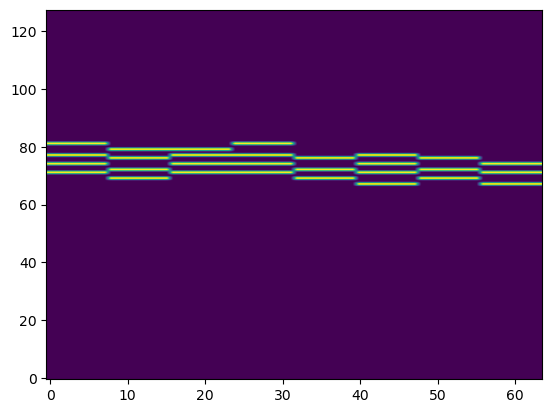

In [12]:
"""
VISUALIZE
"""

%matplotlib inline
piano_roll = pt.utils.music.compute_pianoroll(part)
plt.imshow(piano_roll.todense(), aspect = "auto", origin="lower")